# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [2]:
## The following libraries might be useful
# !pip install -q langchain-openai
# !pip install -U -q langchain-community
# !pip install -U -q langchain-chroma
# !pip install -U -q datasets
# !pip install -U -q ragas
# !pip install -U -q rouge_score

In [3]:
# Import essential libraries

!pip install -q langchain-openai
!pip install -U -q langchain-community
!pip install -U -q langchain-chroma
!pip install -U -q datasets
!pip install -U -q ragas
!pip install -U -q rouge_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [5]:
# Load the files as documents
import os
from langchain_core.documents import Document

def load_documents_with_metadata(corpus_dir):
    all_docs = []

    for category in os.listdir(corpus_dir):
        category_path = os.path.join(corpus_dir, category)
        if not os.path.isdir(category_path):
            continue

        for filename in os.listdir(category_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(category_path, filename)

                with open(file_path, "r", encoding="utf-8") as f:
                    content = f.read()

                # Build LangChain Document with metadata
                doc = Document(
                    page_content=content,
                    metadata={
                        "source": filename,
                        "category": category,
                        "path": file_path
                    }
                )
                all_docs.append(doc)

    return all_docs

# PATH DEFINING
corpus_path = "/content/drive/My Drive/RAG/corpus"
documents = load_documents_with_metadata(corpus_path)

print(f"Loaded {len(documents)} documents.")
print(documents[0].metadata)



Loaded 215 documents.
{'source': 'RROI_Confidentiality_Agreement_Final.txt', 'category': 'contractnli', 'path': '/content/drive/My Drive/RAG/corpus/contractnli/RROI_Confidentiality_Agreement_Final.txt'}


#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [6]:
# to remove stop words installing nltk
!pip install nltk
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Clean and preprocess the data

#Defining the preprocess function

import re
import logging
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
logging.basicConfig(level=logging.INFO)

def preprocess_text(text: str) -> str:
    try:
        # Lowercase
        text = text.lower()

        # Remove emails and phone numbers
        text = re.sub(r'\b[\w.-]+?@\w+?\.\w+?\b', '', text)
        text = re.sub(r'\+?\d[\d\s\-().]{7,}\d', '', text)

        # Remove special characters (keep basic legal symbols)
        text = re.sub(r'[^a-z0-9\s.,;:()\-§]', '', text)

        # Remove stopwords
        words = text.split()
        words = [word for word in words if word not in stop_words]
        text = ' '.join(words)

        # Collapse multiple whitespaces
        text = re.sub(r'\s+', ' ', text).strip()

        return text
    except Exception as e:
        logging.error(f"Error preprocessing text: {e}")
        return ""


In [8]:
# processing steps applying to all the documents

cleaned_documents = []

for doc in documents:
    cleaned_text = preprocess_text(doc.page_content)

    if len(cleaned_text) < 50:
        logging.warning(f"Skipping too-short or empty doc: {doc.metadata['source']}")
        continue

    cleaned_doc = Document(
        page_content=cleaned_text,
        metadata=doc.metadata  # preserve source/category/path
    )

    cleaned_documents.append(cleaned_doc)

print(f"Preprocessed and kept {len(cleaned_documents)} documents.")


Preprocessed and kept 215 documents.


### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [9]:
# Calculate the average, maximum and minimum document length.
# calculating the lenghts in terms of words

word_counts = [len(doc.page_content.split()) for doc in cleaned_documents]

average_words = sum(word_counts) / len(word_counts)
max_words = max(word_counts)
min_words = min(word_counts)

print(f"Average document length (words): {average_words:.2f}")
print(f"Maximum document length (words): {max_words}")
print(f"Minimum document length (words): {min_words}")


Average document length (words): 19381.15
Maximum document length (words): 87550
Minimum document length (words): 220


#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [10]:
# Find frequency of occurence of words

from collections import Counter
import re

# Combine all cleaned document texts
all_text = " ".join(doc.page_content for doc in cleaned_documents)

# Tokenize by splitting on whitespace (since text is cleaned)
words = all_text.split()

# Count frequencies
word_freq = Counter(words)

# 20 most common words
most_common_20 = word_freq.most_common(20)

# 20 least common words (words that occur only once or few times)
# We'll find all words with the lowest frequency, then take 20 of them
min_freq = min(word_freq.values())
least_common_candidates = [w for w, c in word_freq.items() if c == min_freq]
least_common_20 = least_common_candidates[:20]  # take first 20

# Display results
print("20 Most Common Words:")
for word, freq in most_common_20:
    print(f"{word}: {freq}")

print("\n20 Least Common Words (frequency = {min_freq}):")
for word in least_common_20:
    print(word)



20 Most Common Words:
company: 122934
section: 62496
shall: 57854
parent: 48472
agreement: 39048
material: 29192
merger: 28396
subsidiaries: 23860
date: 22738
respect: 22183
stock: 20763
applicable: 19375
prior: 17876
effective: 17019
party: 16849
shares: 16371
(i): 15943
would: 15894
pursuant: 15889
required: 15847

20 Least Common Words (frequency = {min_freq}):
sirmadam:
wheresoever
(alberta);
indemnity:
solicitor-client
incur;
access:
non-solicitation:
solicited:
periodical
circulation;
interpretations:
interpretations,
depend
standstill:
determine:
(alberta))
advisors:
tours
they,


#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

In [11]:
# Transform the page contents of documents
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random

all_texts = [doc.page_content for doc in cleaned_documents]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Compute similarity scores
similarity_matrix = cosine_similarity(tfidf_matrix)



In [12]:
# create a list of 10 random integers

import random
random_indices = random.sample(range(len(all_texts)), 10)
print("Random document indices:", random_indices)


Random document indices: [183, 24, 97, 136, 200, 86, 165, 104, 214, 159]


In [13]:
# Compute similarity scores for 10 random documents


# Extract rows and columns corresponding to random indices
random_sim_matrix = similarity_matrix[np.ix_(random_indices, random_indices)]

print("Similarity matrix for 10 random documents:")
print(np.round(random_sim_matrix, 3))



Similarity matrix for 10 random documents:
[[1.    0.122 0.787 0.862 0.872 0.858 0.898 0.905 0.056 0.879]
 [0.122 1.    0.094 0.108 0.113 0.103 0.12  0.117 0.09  0.136]
 [0.787 0.094 1.    0.734 0.721 0.786 0.734 0.716 0.036 0.739]
 [0.862 0.108 0.734 1.    0.876 0.89  0.895 0.869 0.047 0.874]
 [0.872 0.113 0.721 0.876 1.    0.9   0.958 0.891 0.057 0.94 ]
 [0.858 0.103 0.786 0.89  0.9   1.    0.909 0.863 0.047 0.882]
 [0.898 0.12  0.734 0.895 0.958 0.909 1.    0.923 0.053 0.947]
 [0.905 0.117 0.716 0.869 0.891 0.863 0.923 1.    0.049 0.897]
 [0.056 0.09  0.036 0.047 0.057 0.047 0.053 0.049 1.    0.057]
 [0.879 0.136 0.739 0.874 0.94  0.882 0.947 0.897 0.057 1.   ]]


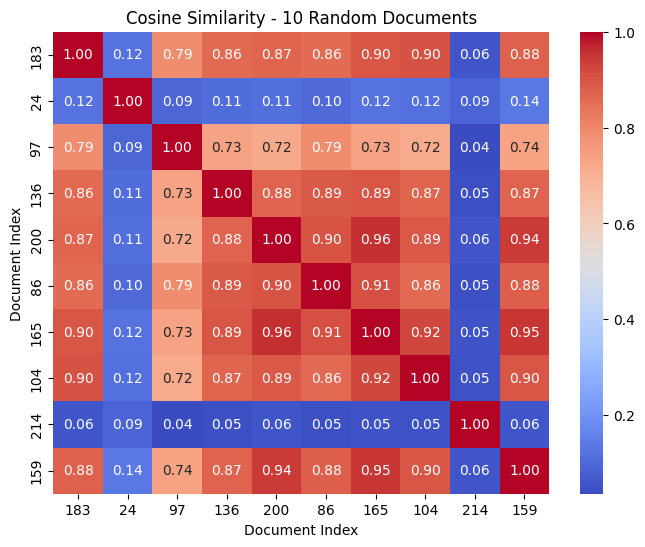

In [14]:
# Visaulisation

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(random_sim_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=random_indices, yticklabels=random_indices)
plt.title("Cosine Similarity - 10 Random Documents")
plt.xlabel("Document Index")
plt.ylabel("Document Index")
plt.show()


### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [15]:
# Process files and generate chunks

from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=100,
    length_function=len
)

# Example: chunk one document
example_doc = cleaned_documents[0].page_content
chunks = text_splitter.split_text(example_doc)

print(f"Number of chunks: {len(chunks)}")
print(chunks[:2])  # print first two chunks

# chunkung all the docs

all_chunks = []
for doc in cleaned_documents:
    chunks = text_splitter.split_text(doc.page_content)
    all_chunks.extend(chunks)

print(f"Total chunks created: {len(all_chunks)}")



Number of chunks: 25
[', 2017 attention: dear sirmadam: re: possible transaction (recipient) red river oil inc. (disclosing party) agreement (the confidentiality agreement) establishes terms conditions disclosing party provide recipient evaluation material (as hereinafter defined) concerning disclosing party. party disclosing evaluation material referred disclosing party party receiving evaluation material referred recipient. parties agree evaluation material provided disclosing party respect potential business transaction disclosing party recipient (the transaction). disclosing party agreed provide recipient access evaluation material subject entering confidentiality agreement setting forth terms conditions pursuant evaluation material provided recipient, including recipients directors, officers, employees,', 'evaluation material provided recipient, including recipients directors, officers, employees, agents, counsel, consultants representatives (collectively, representatives). consid

## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [28]:
# Fetch your OPENAI API Key as an environment variable

#setting up api
os.environ["OPENAI_API_KEY"] = "#####"  # Paste the OpenAI API KEY Here

# Fetching the API_KEY
openai_api_key = os.getenv("OPENAI_API_KEY")


In [17]:
!pip install --upgrade openai


In [30]:
# Initialise an embedding function

import openai


# New function to transform text into vectors using the latest OpenAI API
def text_to_vector(text, model="text-embedding-ada-002"):
    """
    Transform a text string into a vector representation using OpenAI's new Embedding API (v1.0.0+).

    :param text: Input text to be transformed into a vector.
    :param model: The OpenAI model to use for embeddings (default is "text-embedding-ada-002").
    :return: A numpy array representing the text as an embedding vector.
    """
    try:
        # Fetch the embeddings using the new method
        response = openai.embeddings.create(
            model=model,
            input=[text]  # Embedding API now takes a list of inputs
        )

        # Extract the embedding vector from the response
        embedding = response['data'][0]['embedding']

        # Convert to numpy array for further use
        return np.array(embedding)

    except Exception as e:
        print(f"Error while generating embedding: {e}")
        return None

# Example usage
text_example = "This is an example of how we transform text into vectors using OpenAI embeddings."
embedding_vector = text_to_vector(text_example)

# Check first 5 elements of the embedding vector
if embedding_vector is not None:
    print(f"Embedding vector (first 5 values): {embedding_vector[:5]}")


Error while generating embedding: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


In [31]:
# Assuming `all_texts` contains a list of your documents or text chunks
all_embeddings = []

for text in all_chunks:
    embedding = text_to_vector(text)
    if embedding is not None:
        all_embeddings.append(embedding)

# Convert to numpy array for easier handling
all_embeddings = np.array(all_embeddings)




Error while generating embedding: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Error while generating embedding: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Error while generating embedding: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': No

KeyboardInterrupt: 

#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [20]:
# Add Chunks to vector DB

from langchain.vectorstores import FAISS

vectorstore = FAISS(all_embeddings, all_chunks)

# Save the vectorstore locally or to Google Drive
vectorstore.save_local("/content/drive/MyDrive/vector_store")

print("Vectorstore saved successfully!")



### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [21]:
# Create a RAG chain

from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA

# Initializing  LLM

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Creating a retriever from the vectorstore

retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

#  Creating a RAG chain

rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)


#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [22]:
# Create a function for question answering

def answer_question(rag_chain, query):
    """
    Takes a LangChain RetrievalQA chain and a question string.
    Returns the generated answer from the RAG chain.

    Parameters:
        rag_chain (RetrievalQA): The initialized RAG chain.
        query (str): The user question.

    Returns:
        str: The answer generated by the RAG model.
    """
    try:
        answer = rag_chain.run(query)
        return answer
    except Exception as e:
        print(f"Error while answering question: {e}")
        return None


In [23]:
# Example question
# question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"
# response = answer_question(rag_chain, question)
# print("Answer:", response)

## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [24]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set

import json

def extract_questions_and_answers(json_path, use_all_snippets=True):
    """
    Extracts questions and ground truth answers from the benchmark JSON.

    Args:
        json_path (str): Path to the benchmark JSON file.
        use_all_snippets (bool): If True, combine all snippet answers into one answer.

    Returns:
        questions (List[str]): List of question strings.
        ground_truth_answers (List[str]): List of corresponding answer strings.
    """
    with open(json_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    questions = []
    answers = []

    for test in data.get("tests", []):
        question = test.get("query", "").strip()
        snippets = test.get("snippets", [])

        if use_all_snippets:
            combined_answer = " ".join([s.get("answer", "").strip() for s in snippets if s.get("answer")])
            answers.append(combined_answer)
        else:
            first_answer = snippets[0].get("answer", "").strip() if snippets else ""
            answers.append(first_answer)

        questions.append(question)

    return questions, answers

# Path to the benchmark file
benchmark_json_path = "/content/drive/MyDrive/RAG/benchmark/contractnli.json"

# Extract questions and answers
questions, ground_truth_answers = extract_questions_and_answers(benchmark_json_path, use_all_snippets=True)

print(f" Loaded {len(questions)} questions from benchmark.")
print("\n Sample Question:", questions[0])
print(" Ground Truth Answer:", ground_truth_answers[0])


#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [25]:
# Function to evaluate the RAG pipeline

from evaluate import load
from ragas.metrics import (
    answer_similarity,
    faithfulness,
    context_precision,
    context_recall,
    context_relevancy,
)
from ragas.evaluation import evaluate as ragas_evaluate
from datasets import Dataset


def evaluate_rag_outputs(questions, predictions, ground_truths, retrieved_contexts):
    """
    Evaluate RAG-generated answers using ROUGE, BLEU, and RAGAS metrics.

    Args:
        questions (List[str]): List of question strings.
        predictions (List[str]): Generated answers from the RAG system.
        ground_truths (List[str]): Ground truth/reference answers.
        retrieved_contexts (List[List[str]]): Retrieved text chunks per query.

    Returns:
        results (dict): Dictionary containing BLEU, ROUGE, and RAGAS scores.
    """

    # === Evaluate with BLEU ===
    bleu_metric = load("bleu")
    bleu = bleu_metric.compute(
        predictions=predictions,
        references=[[gt] for gt in ground_truths]  # BLEU expects list of list
    )

    # === Evaluate with ROUGE ===
    rouge_metric = load("rouge")
    rouge = rouge_metric.compute(
        predictions=predictions,
        references=ground_truths
    )

    # === Prepare for RAGAS ===
    ragas_dataset = Dataset.from_dict({
        "question": questions,
        "answer": predictions,
        "ground_truth": ground_truths,
        "contexts": retrieved_contexts
    })

    ragas_result = ragas_evaluate(
        ragas_dataset,
        metrics=[
            answer_similarity,
            faithfulness,
            context_precision,
            context_recall,
            context_relevancy
        ]
    )

    # === Compile Results ===
    results = {
        "bleu": bleu["bleu"],
        "rouge": rouge,
        "ragas": {metric.name: score for metric, score in ragas_result.items()}
    }

    return results


#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [26]:
# Evaluate the RAG pipeline

# Limit to first 100 for quick evaluation
N = 100
eval_questions = questions[:N]
eval_answers = ground_truth_answers[:N]

# Generating predictions and contexts
predictions = []
retrieved_contexts = []

for q in eval_questions:
    # Get top-k relevant chunks
    docs = retriever.get_relevant_documents(q)
    retrieved_contexts.append([doc.page_content for doc in docs])

    # Generate answer using the RAG chain
    response = rag_chain.run(q)
    predictions.append(response)

 # Running the full evaluation

results = evaluate_rag_outputs(
    questions=eval_questions,
    predictions=predictions,
    ground_truths=eval_answers,
    retrieved_contexts=retrieved_contexts
)

# Printing the results

print("BLEU Score:", results["bleu"])
print(" ROUGE:")
for k, v in results["rouge"].items():
    print(f"  {k}: {v:.4f}")

print(" RAGAS Scores:")
for metric, val in results["ragas"].items():
    print(f"  {metric}: {val:.4f}")



## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

In [27]:
# Verify if the directory exists
if not os.path.exists(corpus_path):
    print(f"Error: The directory '{corpus_path}' was not found.")
    print("Please check the path and ensure the directory exists in your Google Drive.")
else:
    print(f"Directory '{corpus_path}' found. Proceeding to load documents.")
    documents = load_documents_with_metadata(corpus_path)
    print(f"Loaded {len(documents)} documents.")
    if documents:
        print(documents[0].metadata)

Directory '/content/drive/My Drive/RAG/corpus' found. Proceeding to load documents.
Loaded 215 documents.
{'source': 'RROI_Confidentiality_Agreement_Final.txt', 'category': 'contractnli', 'path': '/content/drive/My Drive/RAG/corpus/contractnli/RROI_Confidentiality_Agreement_Final.txt'}
